In [11]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("/content/drive/MyDrive/fraud_detection_dataset.csv")

In [13]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# EDA

In [16]:
df.isnull().values.any()

False

In [18]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [19]:
df.groupby("isFraud")[["nameOrig","nameDest"]].describe()

nameOrig                            nameDest                        \
           count   unique          top freq    count   unique          top   
isFraud                                                                      
0        6354407  6345122  C1902386530    3  6354407  2719685  C1286084959   
1           8213     8213  C1305486145    1     8213     8169  C1193568854   

              
        freq  
isFraud       
0        113  
1          2

In [20]:
df.groupby(['type','isFraud']).step.count().unstack()

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,528812.0,4097.0


In [21]:
pd.crosstab(df.isFraud, df.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


## Visualizations

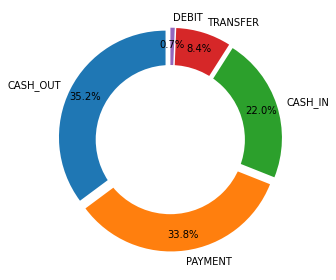

In [22]:
explode = (0.05,0.05,0.05,0.05,0.05)
plt.pie(df.type.value_counts(), labels=['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'], autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) 
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of transactions')

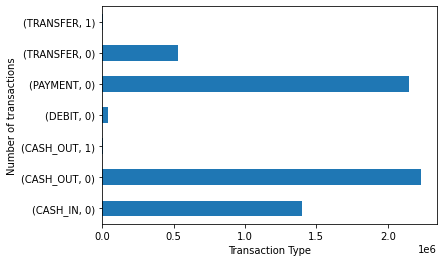

In [23]:
axes = df.groupby(['type', 'isFraud']).size().plot(kind='barh')
axes.set_xlabel("Transaction Type")
axes.set_ylabel("Number of transactions")

# Using LightGBM

In [24]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import graphviz

to_be_dropped=['isFlaggedFraud', 'nameDest', 'nameOrig', 'step', 'type']

dummy_data = pd.get_dummies(df.loc[df.type.apply(lambda x: x in ['CASH_OUT','TRANSFER'])].drop(labels=to_be_dropped,axis=1))

X_train, X_test, y_train, y_test = train_test_split(
    dummy_data.drop('isFraud',axis=1), 
    dummy_data.isFraud, 
    test_size = 0.25, 
    random_state=2019, 
    shuffle=False
)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval  = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Specify configurations as dictionary
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 60,
    'learning_rate': 0.01,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.5,
    'bagging_freq': 25,
    'verbose': 1
}

gbm = lgb.train(params,
            lgb_train,
            num_boost_round=30,
            early_stopping_rounds=25,
            valid_sets=[lgb_train,lgb_eval],
            valid_names=['train', 'eval'])

[1]	train's binary_logloss: 0.0127995	eval's binary_logloss: 0.0410087
Training until validation scores don't improve for 25 rounds.
[2]	train's binary_logloss: 0.0103505	eval's binary_logloss: 0.0321664
[3]	train's binary_logloss: 0.00899156	eval's binary_logloss: 0.0273256
[4]	train's binary_logloss: 0.00888113	eval's binary_logloss: 0.0269469
[5]	train's binary_logloss: 0.0086517	eval's binary_logloss: 0.0261984
[6]	train's binary_logloss: 0.0085582	eval's binary_logloss: 0.0258827
[7]	train's binary_logloss: 0.00844386	eval's binary_logloss: 0.0254967
[8]	train's binary_logloss: 0.00831283	eval's binary_logloss: 0.0250716
[9]	train's binary_logloss: 0.00814529	eval's binary_logloss: 0.024525
[10]	train's binary_logloss: 0.00802052	eval's binary_logloss: 0.0240958
[11]	train's binary_logloss: 0.00792127	eval's binary_logloss: 0.0237751
[12]	train's binary_logloss: 0.0077837	eval's binary_logloss: 0.0233217
[13]	train's binary_logloss: 0.00768486	eval's binary_logloss: 0.0229845
[14]

#Making Conclusions

Plots of feature importance graph with respect to all the types of transactions.

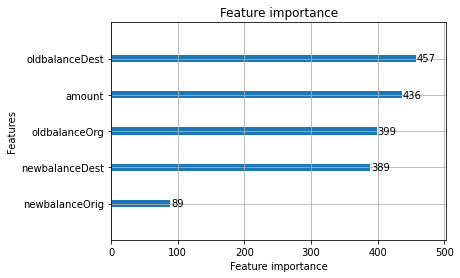

In [25]:
axis = lgb.plot_importance(gbm, max_num_features=10)

A Digraph representation of the decision tree based on the old origin balance and new balance at origin and destination.

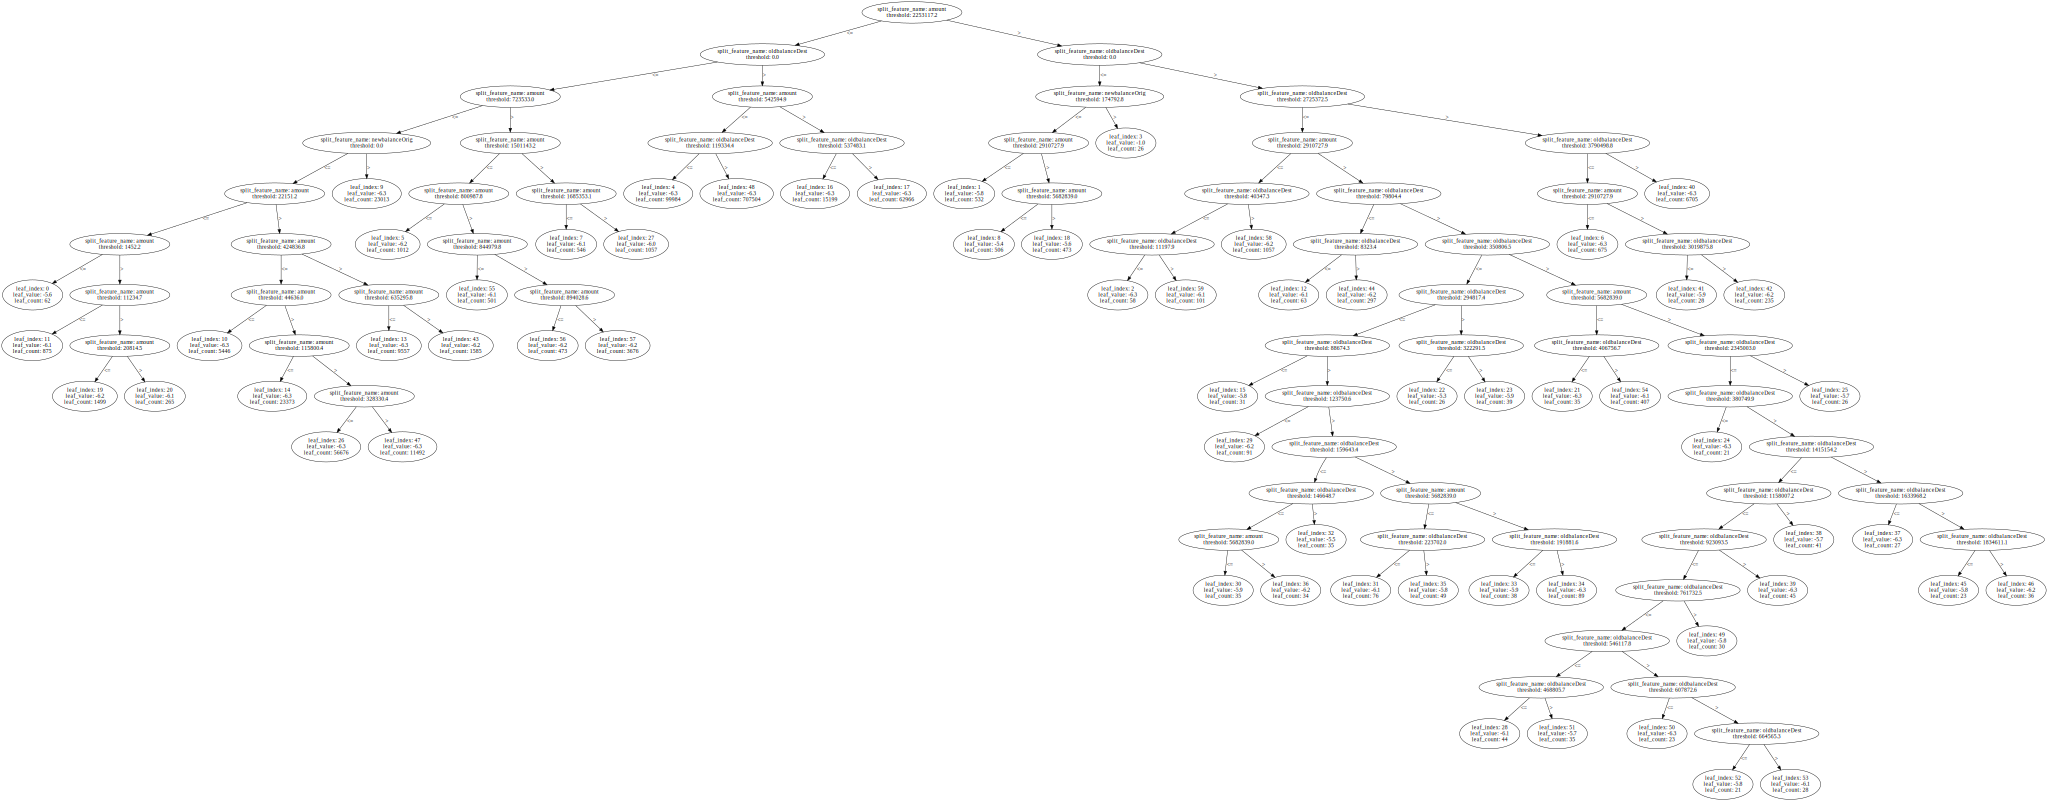

In [28]:
lgb.create_tree_digraph(gbm,tree_index=0,precision=1,show_info=['leaf_count'])

A Digraph representation of the decision tree based on the old origin balance, new origin balance, and transaction amount.  

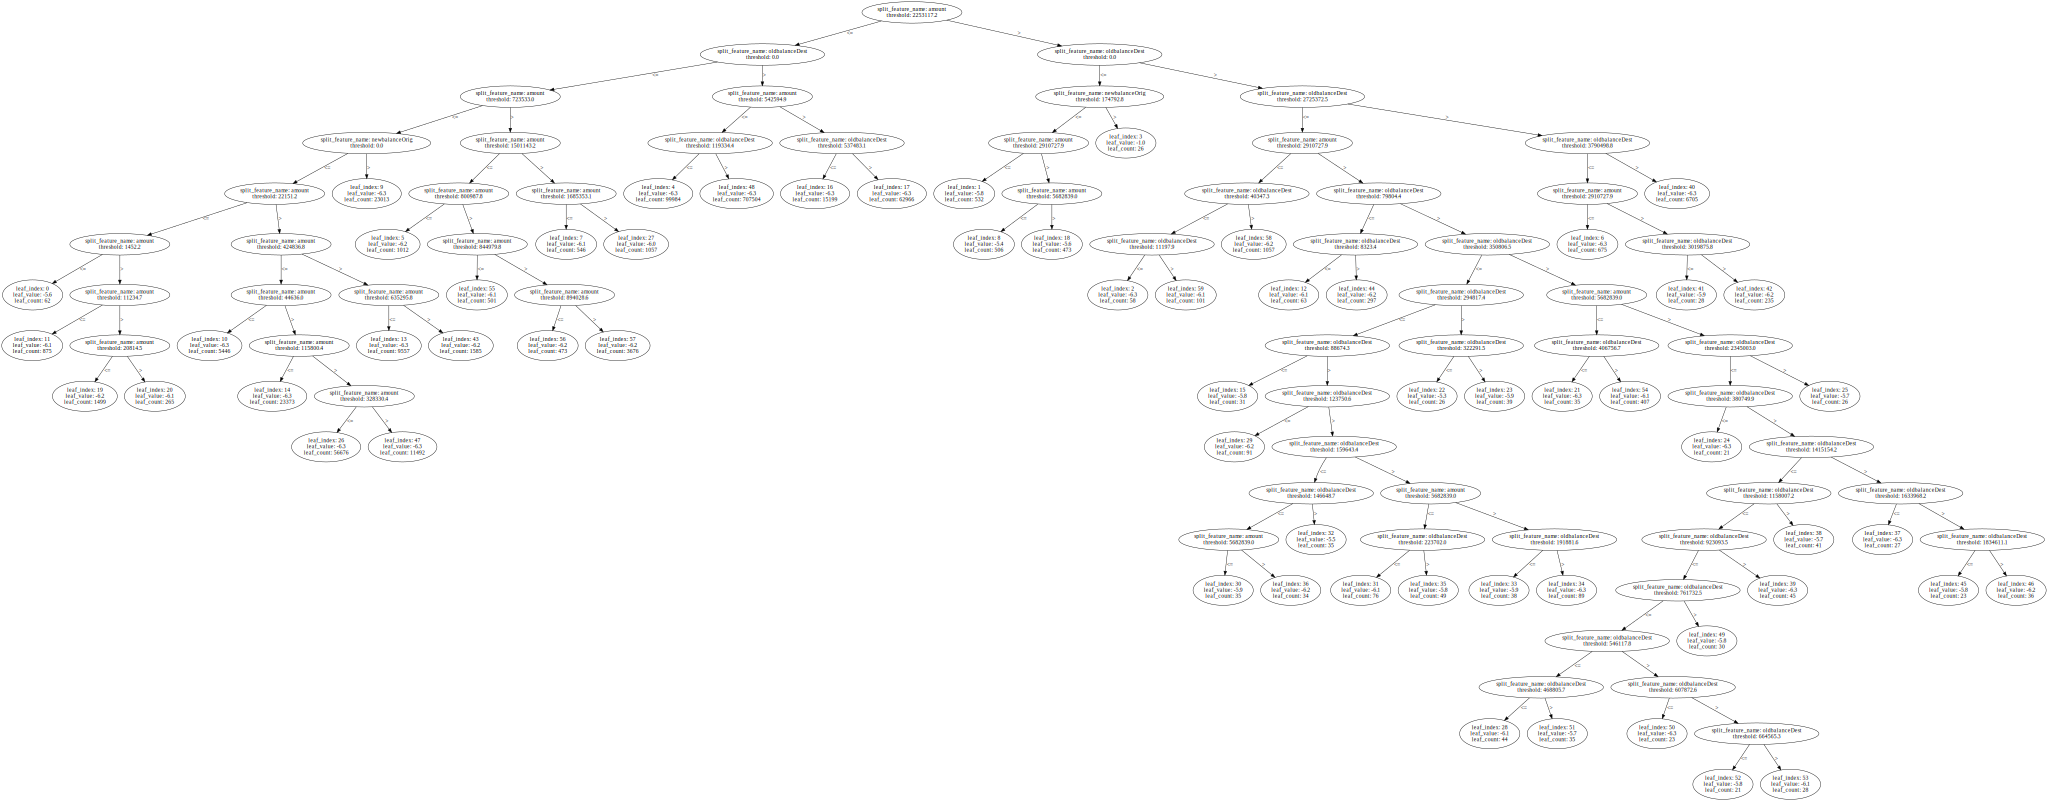

In [33]:
lgb.create_tree_digraph(gbm,tree_index=0,precision=1,show_info=['leaf_count'])

In [30]:
y_test_pred = gbm.predict(X_test)
print('Validation AUC Score: {:.3%}'.format(roc_auc_score(y_test,y_test_pred)))

Validation AUC Score: 98.044%


In [31]:
print('Validation F1 Score: {:.3%}'.format(f1_score(y_test,y_test_pred>0.5)))

Validation F1 Score: 4.793%


In [32]:
pd.crosstab(pd.cut(y_test_pred,np.arange(0,1.01,0.1)),y_test)

isFraud,0,1
row_0,,
"(0.0, 0.1]",688095,2039
"(0.1, 0.2]",24,775
"(0.2, 0.3]",4,810
"(0.3, 0.4]",0,252
"(0.4, 0.5]",0,494
"(0.5, 0.6]",0,104
"(0.9, 1.0]",0,6
